In [1]:
"""
activeness.ipynb 分析全市场股票的股性

    @Time    : 2025/04/24
    @Author  : JackWang
    @File    : activeness.py
    @IDE     : VsCode
    @Copyright Copyright Shihong Wang (c) 2025 with GNU Public License V3.0
"""

# Standard Library
import os
import sys
import platform
from pathlib import Path
from datetime import datetime, timedelta

# Third-Party Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# 如果中文显示错误, 先查看系统所有字体, 找出来一个支持中文的字体填进去
# print(sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist]))


sns.set_theme()
if platform.platform().startswith('Windows'):
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'SimHei'
elif platform.platform().startswith('macOS'):
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'Heiti TC'

# My Library
project_root = str((Path(os.getcwd()) / "../..").resolve())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils.config import load_config
from src.core.tushare_proxy import TuShareProxy
from src.utils.tools import tscode2symbol, concat_df, get_relative_trade_day

config = load_config()
proxy = TuShareProxy(config)

# 读取数据

In [2]:
csv_path = Path(project_root) / "analysis/up_limit_times.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"File {csv_path} does not exist.")

# 读取数据
df = pd.read_csv(csv_path)
df.head(5)

,ts_code,name,up_limit_times
0,002717.SZ,岭南股份,41
1,002693.SZ,双成药业,40
2,600889.SH,南京化纤,32
3,002713.SZ,东易日盛,32
4,600589.SH,大位科技,31


# 涨停次数图

呈现明显的长尾分布

<Axes: xlabel='index', ylabel='up_limit_times'>

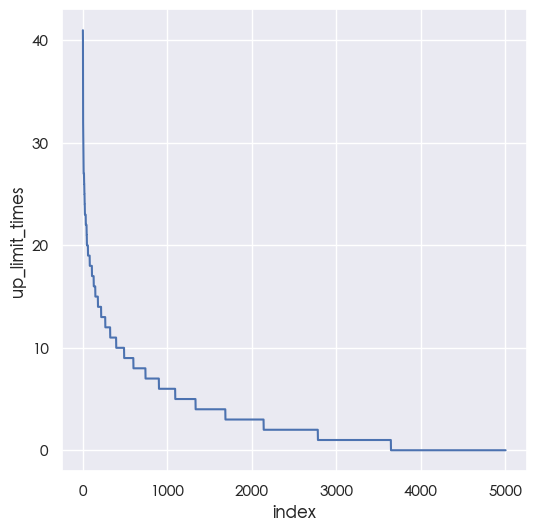

In [3]:
f, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(x="index", y="up_limit_times", data=df.reset_index())

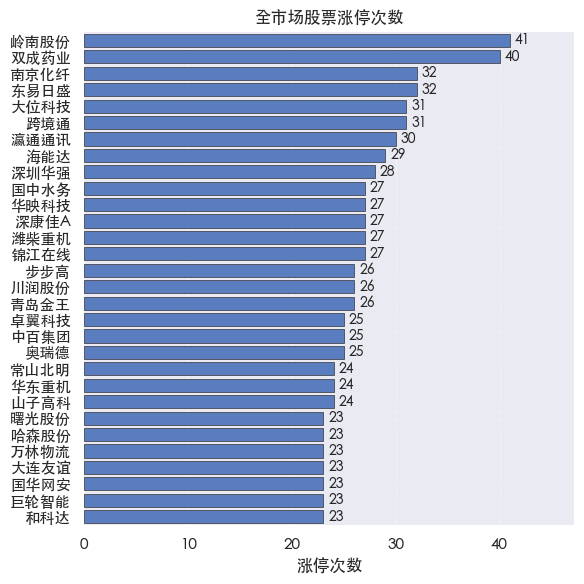

In [4]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("muted")  # 使用柔和色调

barplot = sns.barplot(
    x="up_limit_times", 
    y="name", 
    data=df[:30],
    color="b",          # 蓝色系
    orient="h",         # 横向显示
    edgecolor=".2",     # 边框色
    linewidth=.5        # 边框粗细
)

for p in barplot.patches:
    width = p.get_width()
    ax.text(
        width + 0.5,               # X坐标：柱长+0.5单位
        p.get_y() + p.get_height()/2,  # Y坐标：柱体中央
        f'{int(width)}',           # 显示整数值
        ha='left',                 # 水平左对齐
        va='center',               # 垂直居中
        fontsize=10
    )

ax.set(xlabel="股票名称", ylabel="涨停次数", title="全市场股票涨停次数")
ax.set(
    xlabel="涨停次数",
    ylabel="",
    xlim=(0, df['up_limit_times'].max() * 1.15)  # 留15%空白
)
ax.xaxis.grid(True, linestyle='--', alpha=0.4)   # 只显示横向网格线
sns.despine(left=True, bottom=True)  # 移除左侧和底部边框

plt.tight_layout()  # 自动调整布局

# 28规律验证

涨停次数前27%的股票的涨停次数占了市场全部涨停次数的72%, 符合28规律

阈值在5, 即过去一年中涨停次数大于5次是一个分水岭.
 - 有 1334 只股票过去一年涨停次数超过5次, 贡献了 12639 次涨停, 占比 71.98%
 - 有 3672 只股票过去一年涨停次数小于5次, 贡献了 4920 次涨停, 占比 28.02%

所以, 过去一年涨停次数超过五次就可以算作A股中的核心股

(np.float64(0.7236744689333106), np.float64(0.27632553106668944))

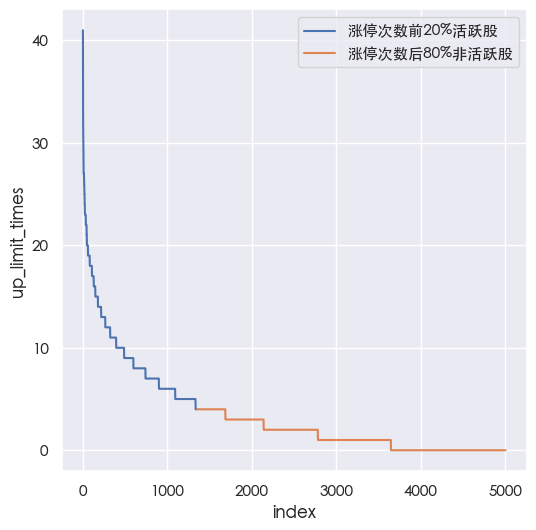

In [48]:
num_shares = len(df)
num_active_shares = int(0.27 * num_shares)

f, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(x="index", y="up_limit_times", data=df.reset_index()[:num_active_shares], label="涨停次数前20%活跃股")
sns.lineplot(x="index", y="up_limit_times", data=df.reset_index()[num_active_shares:], label="涨停次数后80%非活跃股")

total_up_times = df.iloc[:, -1].sum()
active_up_times = df.iloc[:num_active_shares, -1].sum()
non_active_up_times = df.iloc[num_active_shares:, -1].sum()
active_up_times/ total_up_times, non_active_up_times / total_up_times

In [49]:
freq_table = df["up_limit_times"].value_counts().sort_index().reset_index()

mask = freq_table["up_limit_times"] >= 5
a = (freq_table[mask]["count"] * freq_table[mask]["up_limit_times"]).sum()
b = (freq_table[~mask]["count"] * freq_table[~mask]["up_limit_times"]).sum()
a, b, a / (a + b), b / (a + b), freq_table[mask]["count"].sum(), freq_table[~mask]["count"].sum()

(np.int64(12639),
 np.int64(4920),
 np.float64(0.719801811037075),
 np.float64(0.280198188962925),
 np.int64(1334),
 np.int64(3672))

# 涨停次数分布表
针对核心股, 对其进行等宽分组, 一共分为三组, 分别是:
- 涨停次数5~13: 1118只股票
- 涨停次数14~27: 207只股票
- 涨停次数28-31: 9只股票


In [69]:
core_mask = df["up_limit_times"] >= 5
core_df = df[core_mask].copy()
core_df["group"] = pd.cut(df["up_limit_times"], bins=3)
core_df["symbol"] = df["ts_code"].apply(tscode2symbol)
core_df.head(5)

,ts_code,name,up_limit_times,group,symbol
0,002717.SZ,岭南股份,41,"(27.333, 41.0]",002717
1,002693.SZ,双成药业,40,"(27.333, 41.0]",002693
2,600889.SH,南京化纤,32,"(27.333, 41.0]",600889
3,002713.SZ,东易日盛,32,"(27.333, 41.0]",002713
4,600589.SH,大位科技,31,"(27.333, 41.0]",600589


In [70]:
groups = core_df["group"].cat.categories
group_counts = core_df['group'].value_counts().sort_index()
groups, group_counts

(IntervalIndex([(-0.041, 13.667], (13.667, 27.333], (27.333, 41.0]], dtype='interval[float64, right]'),
 group
 (-0.041, 13.667]    1118
 (13.667, 27.333]     207
 (27.333, 41.0]         9
 Name: count, dtype: int64)

导出为同花顺支持的格式, 从而添加入自选板块

In [72]:
analysis_dir = csv_path.parent

with (analysis_dir / "core_shares.txt").open(mode="w") as f:
    f.write("\n".join(core_df["symbol"].tolist()))

g: pd.Interval
for i, g in enumerate(groups[::-1]):
    with (analysis_dir / f"top{i + 1}group.txt").open(mode="w") as f:
        f.write("\n".join(core_df[core_df["group"] == g]["symbol"].tolist()))

# 查看过去一周涨停股在活跃股中的命中率